In [3]:
import pandas as pd
from sklearn.model_selection import  train_test_split
import pickle
import xgboost
import numpy as np

Вводные данные

У нас тут датасет титаника, который мы необного приобразовываем и на нём обучаем модель XGBClassifier<br/>
Никаких особых очисток нет, модель получается довольно средненькая, но нам оно и не нужно для проверки гипотезы

In [4]:
df = pd.read_csv("./data/titanic.csv")
df = df[["Pclass", "Sex", "Age", "SibSp", "Parch","Fare", "Cabin", "Embarked", "Survived"]]
df["Cabin"] = [x[0] if type(x) == str else "No Data" for x in df["Cabin"].values]
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,No Data,S,0
1,1,female,38.0,1,0,71.2833,C,C,1
2,3,female,26.0,0,0,7.9250,No Data,S,1
3,1,female,35.0,1,0,53.1000,C,S,1
4,3,male,35.0,0,0,8.0500,No Data,S,0


In [5]:
df = df.dropna().reset_index(drop=True)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,No Data,S,0
1,1,female,38.0,1,0,71.2833,C,C,1
2,3,female,26.0,0,0,7.9250,No Data,S,1
3,1,female,35.0,1,0,53.1000,C,S,1
4,3,male,35.0,0,0,8.0500,No Data,S,0


In [6]:
from sklearn import preprocessing
for column in ["Sex", "Cabin", "Embarked"]:
    le = preprocessing.LabelEncoder()
    le.fit(df[column].values)
    df[column] = le.transform(df[column])

df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,1,22.0,1,0,7.2500,7,2,0
1,1,0,38.0,1,0,71.2833,2,0,1
2,3,0,26.0,0,0,7.9250,7,2,1
3,1,0,35.0,1,0,53.1000,2,2,1
4,3,1,35.0,0,0,8.0500,7,2,0


In [7]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_train, y_train)

In [9]:
df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,1,22.0,1,0,7.2500,7,2,0
1,1,0,38.0,1,0,71.2833,2,0,1
2,3,0,26.0,0,0,7.9250,7,2,1
3,1,0,35.0,1,0,53.1000,2,2,1
4,3,1,35.0,0,0,8.0500,7,2,0
...,...,...,...,...,...,...,...,...,...
707,3,0,39.0,0,5,29.1250,7,1,0
708,2,1,27.0,0,0,13.0000,7,2,0
709,1,0,19.0,0,0,30.0000,1,2,1
710,1,1,26.0,0,0,30.0000,2,0,1


In [18]:
import shap
from sklearn.tree import DecisionTreeRegressor, plot_tree, _tree
from matplotlib import pyplot as plt

Сама функция, которая строит дерево и отображает картинку<br/>

В качестве дерева используется самый простой TreeExplainer, в данные мы добавляем новое поле, которое хранит важность изучаемой переменной для текущей записи<br/>
Y я решил всё-таки дропнуть, думаю слишком большая корреляция будет между данными

In [38]:
def fit_decition_tree(X, y, depth):
    clf = DecisionTreeRegressor(max_depth=depth)
    clf = clf.fit(X, y)

    return clf

def get_shap_values_for_tree(model, X, y):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X, y=y)
    return shap_values

def get_cleaned_data_for_shap(df):
    clean_df = df.dropna()
    X = clean_df.drop("Survived", axis=1)
    y = clean_df["Survived"]
    return X, y

def get_feature_index(feature_name, X):
    return list(X.columns).index(feature_name)

def get_feature_shap_vals(shap_values, feature_index):
    return shap_values[:,feature_index]

def plot_fig_for_tree(clf, feature_names):
    fig = plt.figure(figsize=(15,5))
    _ = plot_tree(clf, filled=True, feature_names=feature_names)

    

def get_decition_tree_for_feature(model, df, feature_name, depth, should_remove_original_feature=False):
    X, y = get_cleaned_data_for_shap(df)
    shap_values = get_shap_values_for_tree(model, X, y)

    feature_index = get_feature_index(feature_name, X)
    feature_shap_vals = get_feature_shap_vals(shap_values, feature_index)
    if should_remove_original_feature:
        X = X.drop(feature_name, axis=1)

    # print(pd.DataFrame(feature_shap_vals).describe())

    clf = fit_decition_tree(X, feature_shap_vals, depth)

    plot_fig_for_tree(clf, X.columns)

def get_decition_tree_text_for_feature(model, df, feature_name, depth, should_remove_original_feature=False):
    X, y = get_cleaned_data_for_shap(df)
    shap_values = get_shap_values_for_tree(model, X, y)
    
    feature_index = get_feature_index(feature_name, X)
    feature_shap_vals = get_feature_shap_vals(shap_values, feature_index)   
    
    if should_remove_original_feature:
        X = X.drop(feature_name, axis=1)

    # print(pd.DataFrame(feature_shap_vals).describe())

    clf = fit_decition_tree(X, feature_shap_vals, depth)

    return clf, X




In [40]:
def get_rules(tree, feature_names, index):
    tree_ = tree.tree_
    feature_name = [feature_names[i] for i in tree_.feature]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "Если "
        
        for p in path[:-1]:
            if rule != "Если ":
                rule += " И "
            rule += f"{p}"
        rule += f" Тогда Важность_{index}="+str(np.round(path[-1][0][0][0],3))
        rules += [rule]
        
    return rules

def get_rules_for_features(model_xgb, df, features, depth):
    rules = []

    for i, f in enumerate(features):
        clf, X = get_decition_tree_text_for_feature(model_xgb, df, f, depth)
        rules += get_rules(clf, X.columns, i)

    return rules

def format_rules_as_str(rules):
    return "\n".join(rules)

def fix_comparison(rules_str):
    replace_rules = {
        "Sex > 0.5": "Sex = M",
        "Sex <= 0.5": "Sex = F",
        "Pclass > 2.5": "Pclass = High",
        "Pclass <= 2.5": "Pclass = Low",
    }
    for from_, to in replace_rules.items():
        rules_str = rules_str.replace(from_, to)

    return rules_str

    

In [45]:
rules = get_rules_for_features(model_xgb, df, ['Sex', 'Age', 'Pclass'], 4)
rules_str = format_rules_as_str(rules)
rules_str = fix_comparison(rules_str)
print(rules_str)

Если (Sex = M) И (Pclass = High) И (Age > 13.0) И (Fare > 7.6) Тогда Важность_0=-0.941
Если (Sex = M) И (Pclass = Low) И (Age > 13.5) И (Cabin > 6.0) Тогда Важность_0=-1.364
Если (Sex = M) И (Pclass = Low) И (Age > 13.5) И (Cabin <= 6.0) Тогда Важность_0=-1.223
Если (Sex = F) И (Pclass = Low) И (Age > 10.5) И (Cabin <= 6.0) Тогда Важность_0=2.268
Если (Sex = F) И (Pclass = High) И (Age > 12.0) И (Fare > 7.742) Тогда Важность_0=1.654
Если (Sex = F) И (Pclass = Low) И (Age > 10.5) И (Cabin > 6.0) Тогда Важность_0=2.416
Если (Sex = M) И (Pclass = High) И (Age > 13.0) И (Fare <= 7.6) Тогда Важность_0=-1.058
Если (Sex = M) И (Pclass = High) И (Age <= 13.0) И (Age <= 6.5) Тогда Важность_0=-0.464
Если (Sex = F) И (Pclass = High) И (Age <= 12.0) И (Age > 3.5) Тогда Важность_0=0.943
Если (Sex = M) И (Pclass = High) И (Age <= 13.0) И (Age > 6.5) Тогда Важность_0=-0.543
Если (Sex = F) И (Pclass = High) И (Age <= 12.0) И (Age <= 3.5) Тогда Важность_0=0.782
Если (Sex = F) И (Pclass = High) И (Age >

In [125]:
rules = get_rules(clf, X.columns)

def rule_sort(x):
    val = float(x.split('Importance=')[1])
    return abs(val)

rules = sorted(rules, key=rule_sort, reverse=True)

def clean_rule(x):
    token_map = {
        "If ": '',
        "(": '',
        ")": '',
        "And": "&",
        "Then": "->"
    }
    for t1, t2 in token_map.items():
        x = x.replace(t1, t2)
    return x

for i, x in enumerate(rules, start=1):
    clean_x = clean_rule(x)
    print(f"{i}. {clean_x}")

1. Sex <= 0.5 & Pclass <= 2.5 -> Importance=2.294
2. Sex <= 0.5 & Pclass > 2.5 -> Importance=1.495
3. Sex > 0.5 & Pclass <= 2.5 -> Importance=-1.273
4. Sex > 0.5 & Pclass > 2.5 -> Importance=-0.921


In [94]:
rules = get_rules(clf, X.columns)
rules
print("\n".join(rules))

Если (Sex > 0.5) И (Pclass > 2.5) И (Age > 13.0) То Importance=-0.968
Если (Sex > 0.5) И (Pclass <= 2.5) И (Age > 13.5) То Importance=-1.302
Если (Sex <= 0.5) И (Pclass <= 2.5) И (Age > 10.5) То Importance=2.335
Если (Sex <= 0.5) И (Pclass > 2.5) И (Age > 12.0) То Importance=1.673
Если (Sex > 0.5) И (Pclass > 2.5) И (Age <= 13.0) То Importance=-0.499
Если (Sex <= 0.5) И (Pclass > 2.5) И (Age <= 12.0) То Importance=0.88
Если (Sex > 0.5) И (Pclass <= 2.5) И (Age <= 13.5) То Importance=-0.823
Если (Sex <= 0.5) И (Pclass <= 2.5) И (Age <= 10.5) То Importance=1.611


In [ ]:
High - правила с большим абсолютным Importance
Middle - правила со средним абсолютным Importance
Low - правила с малым абсолютным Importance

In [97]:
Соотнеси категории с правилами из следующего сообщения. 
Категория напрямую зависит от значения переменной Importance
Категории: 
High_Plus - Высокое положительное значение важности у правила.
High_Minus - Высокое отрицательное значение важности у правила.
Mid_Plus - Средее положительное значение важности у правила.
Mid_Minus - Сренднее отрицательное значение важности у правила.
Low_Plus - Малое положительное значение важности у правила.
Low_Minus - Малое отрицательное значение важности у правила.
OTHER - Остальные правила, которые не подпаюбают под описаные выше.
В ответ выведи категории со списком правил, которые к ним относятся.
Задача понятна?

SyntaxError: invalid syntax (1299777262.py, line 1)

In [ ]:
Соотнеси категории с правилами из следующего сообщения. 
Категории: 
High_Plus - Высокое положительное значение важности у правила.
High_Minus - Высокое отрицательное значение важности у правила.
Mid_Plus - Средее положительное значение важности у правила.
Mid_Minus - Сренднее отрицательное значение важности у правила.
Low_Plus - Малое положительное значение важности у правила.
Low_Minus - Малое отрицательное значение важности у правила.
OTHER - Остальные правила, которые не подпаюбают под описаные выше.
В ответ выведи категории со списком правил, которые к ним относятся.
Задача понятна?

                0
count  712.000000
mean     0.034887
std      1.509789
min     -1.506256
25%     -1.152437
50%     -0.927717
75%      1.674192
max      2.697670


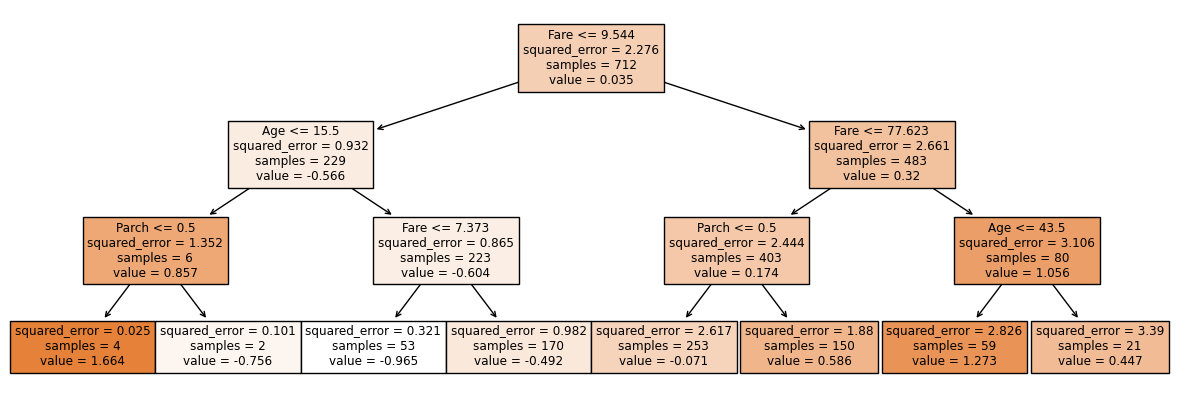

In [65]:
get_decition_tree_for_feature(model_xgb, df, 'Sex', 3, True)

                0
count  712.000000
mean     0.034887
std      1.509789
min     -1.506256
25%     -1.152437
50%     -0.927717
75%      1.674192
max      2.697670


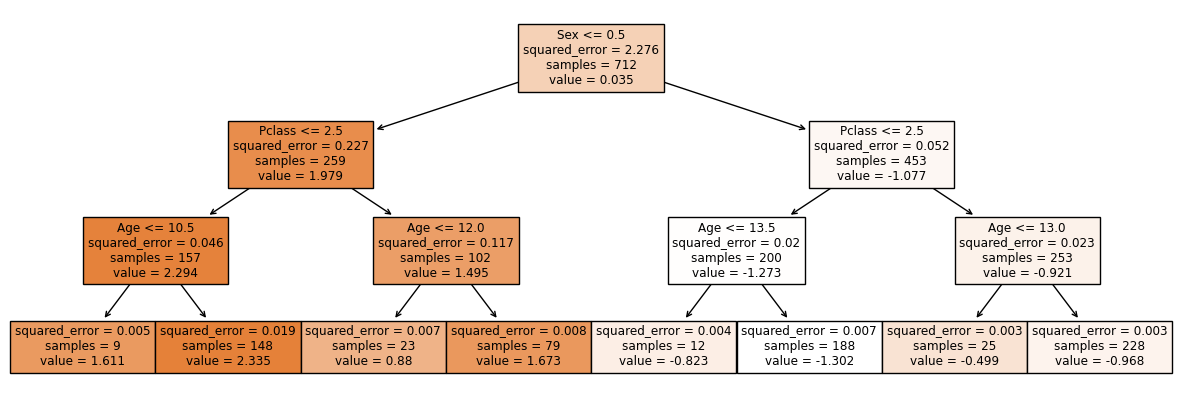

In [28]:
get_decition_tree_for_feature(model_xgb, df, 'Sex', 3)

По датасету титаника известно, что самые важнные в нём показатели это пол и возраст<br/>
Собственно деревья глубины 1 и 2 это чётко показывают<br/>
Глубины 1 показывает, что если ты женщина (Sex = 0), то важность переменной равнаяется почти 2<br/>
У мужчин обратная ситуация важность переменной отрицательная

                0
count  712.000000
mean     0.034887
std      1.509789
min     -1.506256
25%     -1.152437
50%     -0.927717
75%      1.674192
max      2.697670


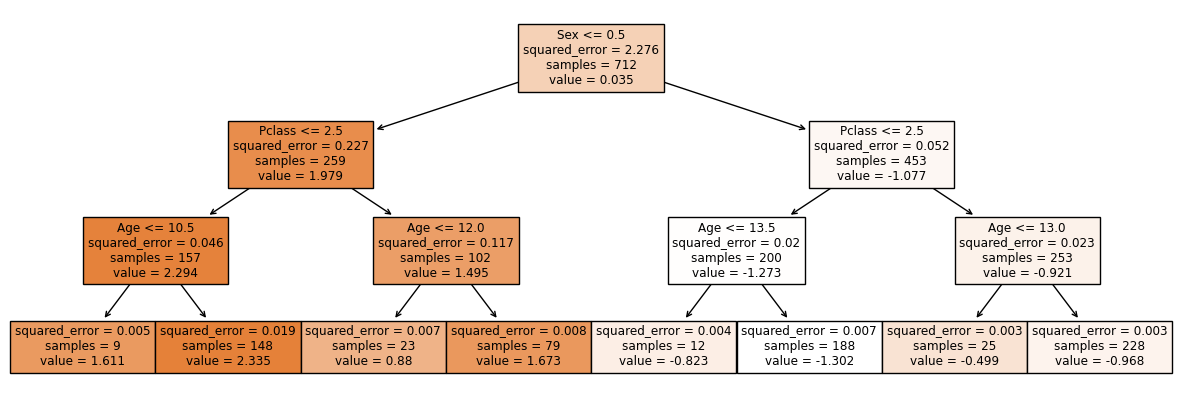

In [10]:
get_decition_plot_for_feature(model_xgb, df, "Sex", 3)

Вложеность 2 выглядит интереснее, тут виндо, что если мы копнём чуть глубже, то станет понятно, что для того, чтобы выжить, нужно быть
1. Женщиной
2. из Pclass 1 или 2 (класс обслуживания кажется)

Причём удивительно, что Мужчины из Pclass 1 и 2 наоборот имеют более низкий шанс выжить, чем мужчины из класса 3.<br/>
Скорее всего тут идёт переток выживания от мужчин к женщинам. Образно говоря, они находились в одном и том же территориально месте и уступали места на шлюпках<br/>
Когда в классе 3 это происходило чуть реже 

In [11]:
df["Pclass"].unique()

array([3, 1, 2], dtype=int64)

                0
count  712.000000
mean     0.034887
std      1.509789
min     -1.506256
25%     -1.152437
50%     -0.927717
75%      1.674192
max      2.697670


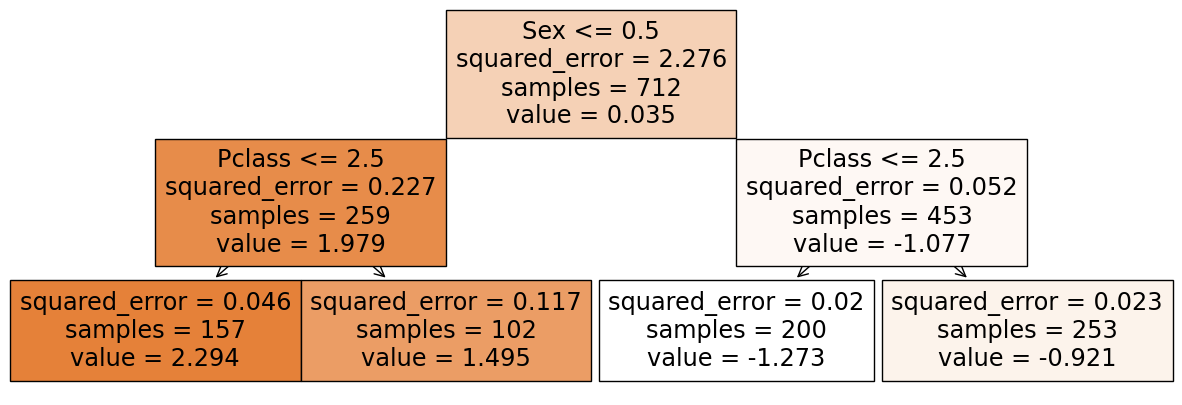

In [12]:
get_decition_plot_for_feature(model_xgb, df, "Sex", 2)

Тут с возрастом всё очень просто на вложености 1 - дети идут в шлюпки первые, остальные как получится 

                0
count  712.000000
mean    -0.033717
std      0.973651
min     -2.118645
25%     -0.500665
50%     -0.223475
75%      0.023869
max      4.246774


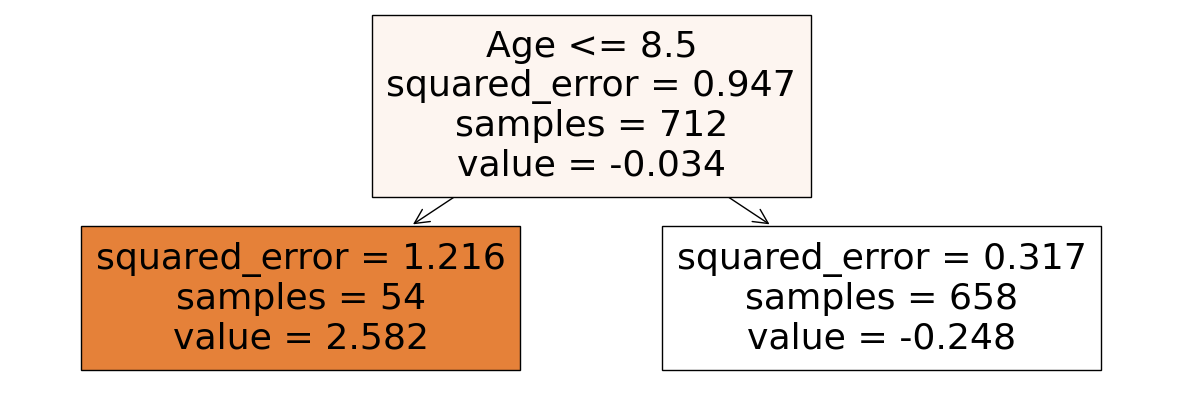

In [13]:
get_decition_plot_for_feature(model_xgb, df, "Age", 1)

На вложености 2 уже сильно интереснее<br/>
Тут видно, что для повышения выживания, нужно быть ребёнком без сиблингов 

При этом только возраст больше 52,5 очень сильно снижал шанс на выживание, возраст от 8,5 до 52,5 имел небольшую отрицательную важность

                0
count  712.000000
mean    -0.033717
std      0.973651
min     -2.118645
25%     -0.500665
50%     -0.223475
75%      0.023869
max      4.246774


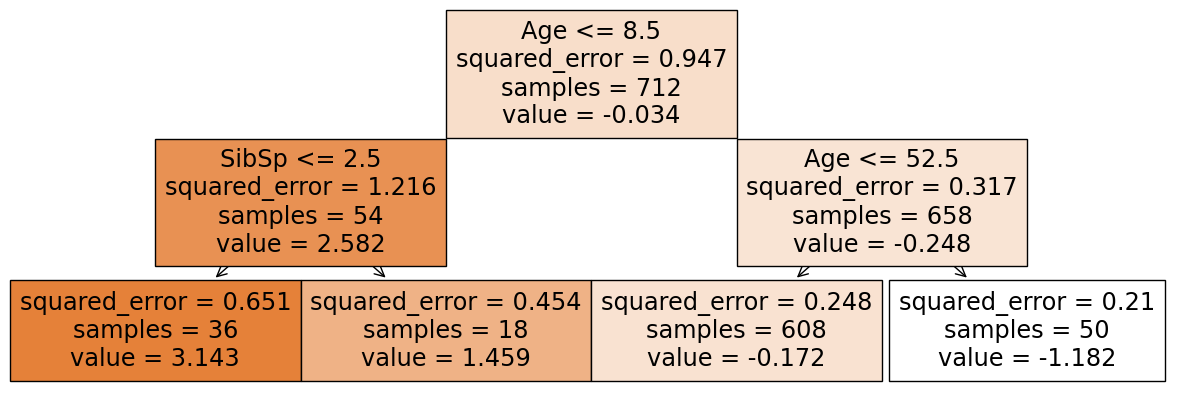

In [14]:
get_decition_plot_for_feature(model_xgb, df, "Age", 2)

С классом вложености 1 походе на то же самое, что было с полом и вложеность 2<br/>
А именно, что класс не 3, давал прибавку к выживанию

                0
count  712.000000
mean    -0.004620
std      0.736692
min     -1.052711
25%     -0.470728
50%     -0.055406
75%      0.686574
max      1.290073


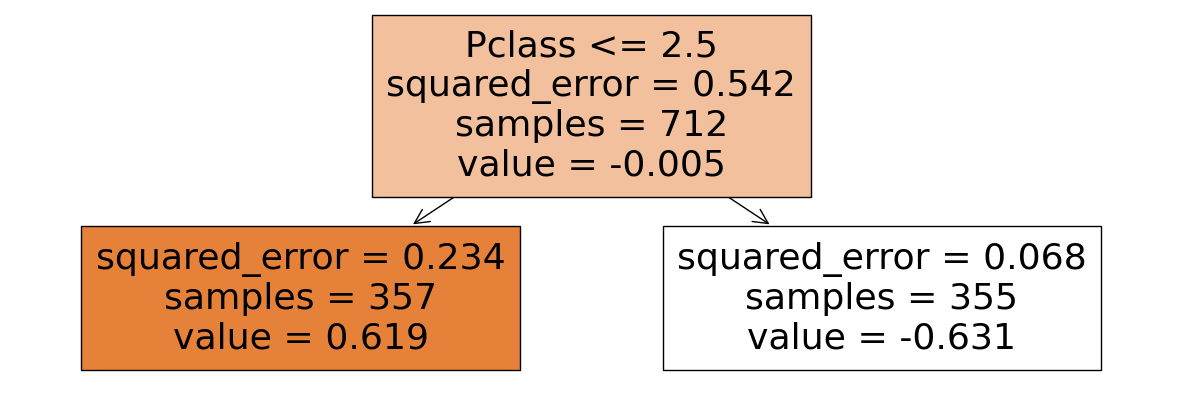

In [15]:
get_decition_plot_for_feature(model_xgb, df, "Pclass", 1)

Вложеность 2 уже интереснее <br/>
Тут становится очевидно, что женшины из 3 класса имели довольно низкие шансы на выживание

При этом ещё видно, что 1 класс ещё лучше чем 2

                0
count  712.000000
mean    -0.004620
std      0.736692
min     -1.052711
25%     -0.470728
50%     -0.055406
75%      0.686574
max      1.290073


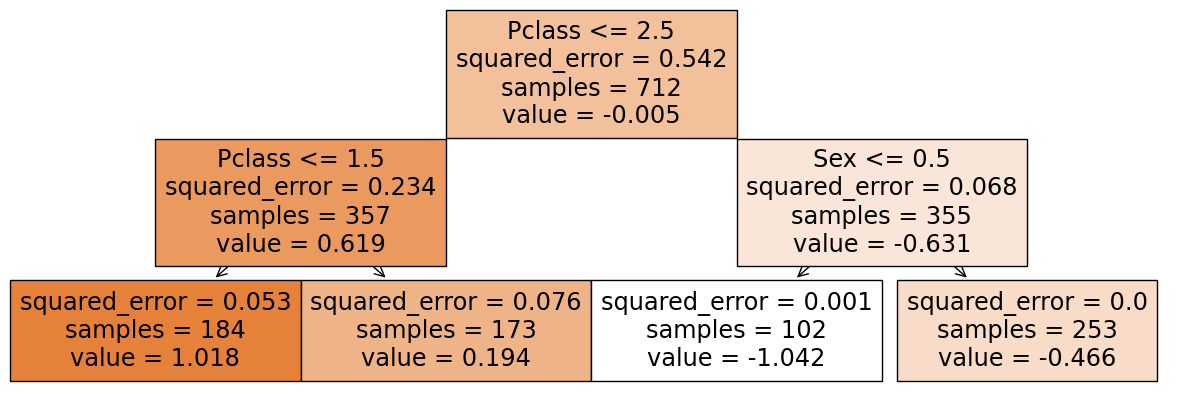

In [16]:
get_decition_plot_for_feature(model_xgb, df, "Pclass", 2)

                0
count  712.000000
mean    -0.044517
std      0.534375
min     -1.393517
25%     -0.454834
50%      0.026133
75%      0.361709
max      1.353623


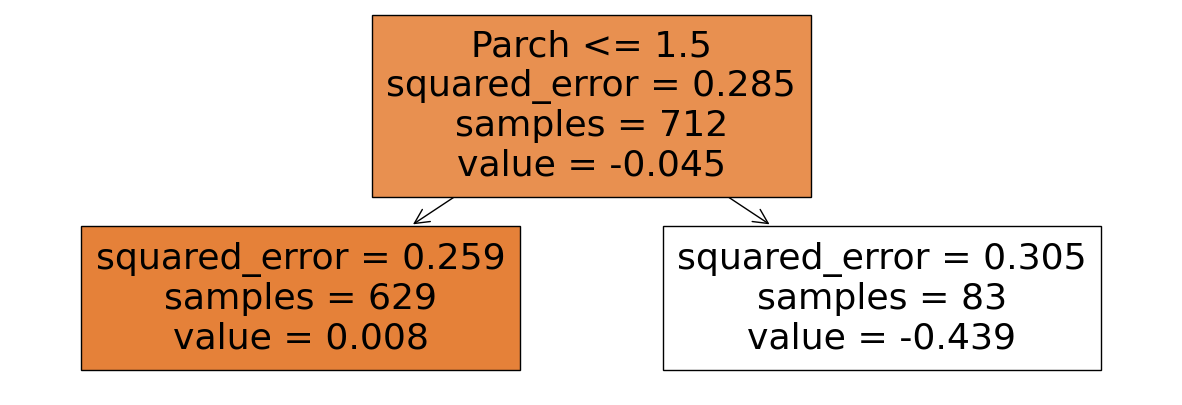

In [17]:
get_decition_plot_for_feature(model_xgb, df, "Fare", 1)

По числу сиблингов вот ещё одно подтверждение, что было в возрасте глубиной 2

Много сиблингов - низкие шансы выжить

                0
count  712.000000
mean     0.016472
std      0.414119
min     -2.260145
25%      0.054316
50%      0.088254
75%      0.088254
max      0.639281


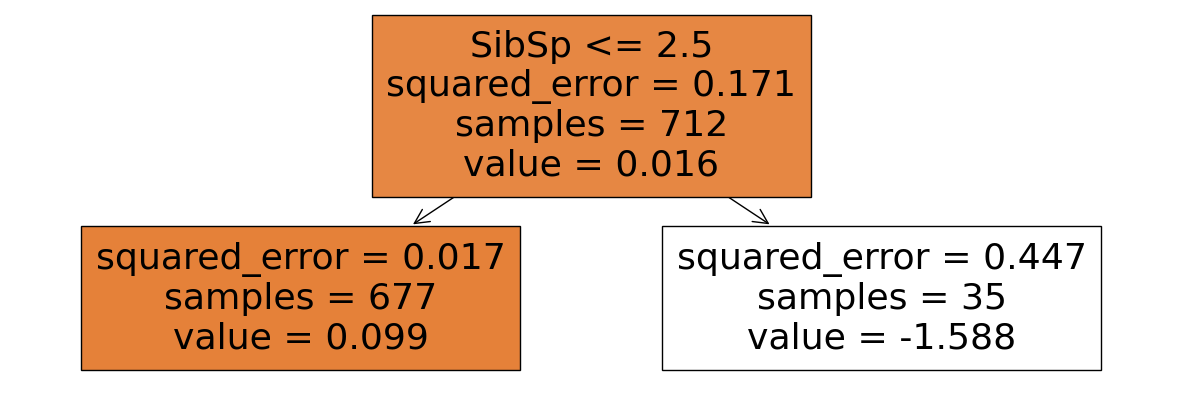

In [18]:
get_decition_plot_for_feature(model_xgb, df, "SibSp", 1)

А вот тут прям обратная корреляция с тем, что было в возрасте с глубиной 2

                0
count  712.000000
mean     0.016472
std      0.414119
min     -2.260145
25%      0.054316
50%      0.088254
75%      0.088254
max      0.639281


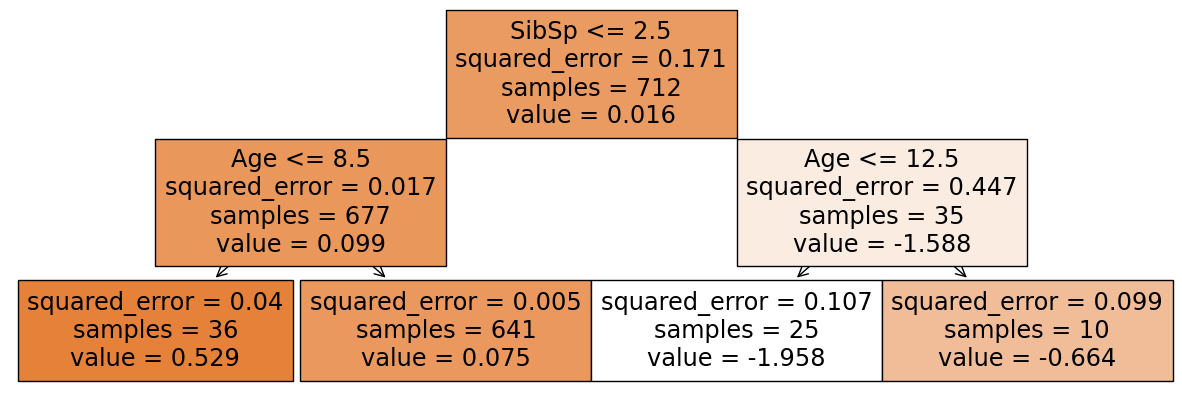

In [19]:
get_decition_plot_for_feature(model_xgb, df, "SibSp", 2)

<h1>Резюме<h1/>

Самые важные переменные датасеты давно известны, так как он очень популярен<br/>
Очень круто, что эти деревья очень точно коррелиуют, с теми выводами, что были сделаны уже давно<br/>

Исходя из проверенной выше гипотезы, можно предположить, что данный механизм поиска внутренних закономерностей в датасете/модели должен работать и на других данных<br/>
Можно интегрировать подобные графики в уже разработанную программу и это будет ещё один способ "понимания" модели

In [72]:
import seaborn as sns

<Axes: >

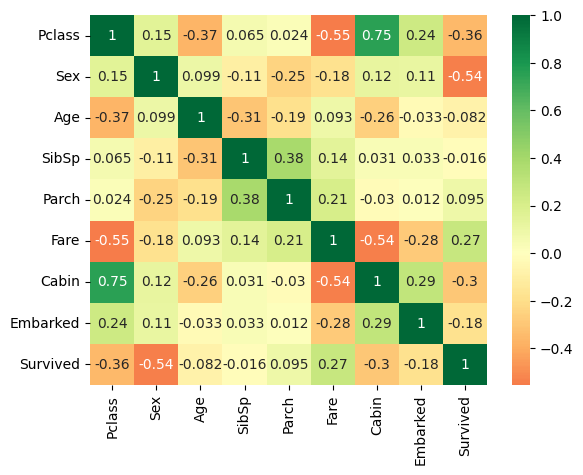

In [73]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)